# Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight

# Understanding the Dataset

In [2]:
path = os.path.join('datasets', 'creditcard', 'creditcard.csv')
pf = pd.read_csv(path)

In [3]:
# First five rows of the dataset
pf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### This dataset includes 
- **30 features**
- one label column which is the **class of transactions**, **0** for **normal transactions** and **1** for **fraudulent transactions**
- No **null value**


In [4]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Class imbalance

As expected, the credit card dataset is imbalanced, which means there are too many non-fraudulent (normal) transactions compared to fraudulent ones. 
In our case, there are: 
- **284315** normal transactions against only 
- **492** fraudulent transactions. 

As we'll see, this skewed data can affect the accuracy of the models. 

In [66]:
pf["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Feature scaling

Features have different scale! 

With the data description and histograms, we can see that 
- **V's features** are spread around **0** while
- **Time** and **Amount** ranges respectively from  **0** to **172792** and  **0** to **25691**.

This can affect the efficiency of the gradient descent algorithm. Indeed, it may take too long to converge.

To avoid this problem, we need to perform a data transformation called **feature scaling** on our features Time and Amount.
I'll apply the MinMax Normalization: 
$$x_i = \dfrac{x_i - min}{max - min} $$

In [67]:
# Quick statistical insights
pf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

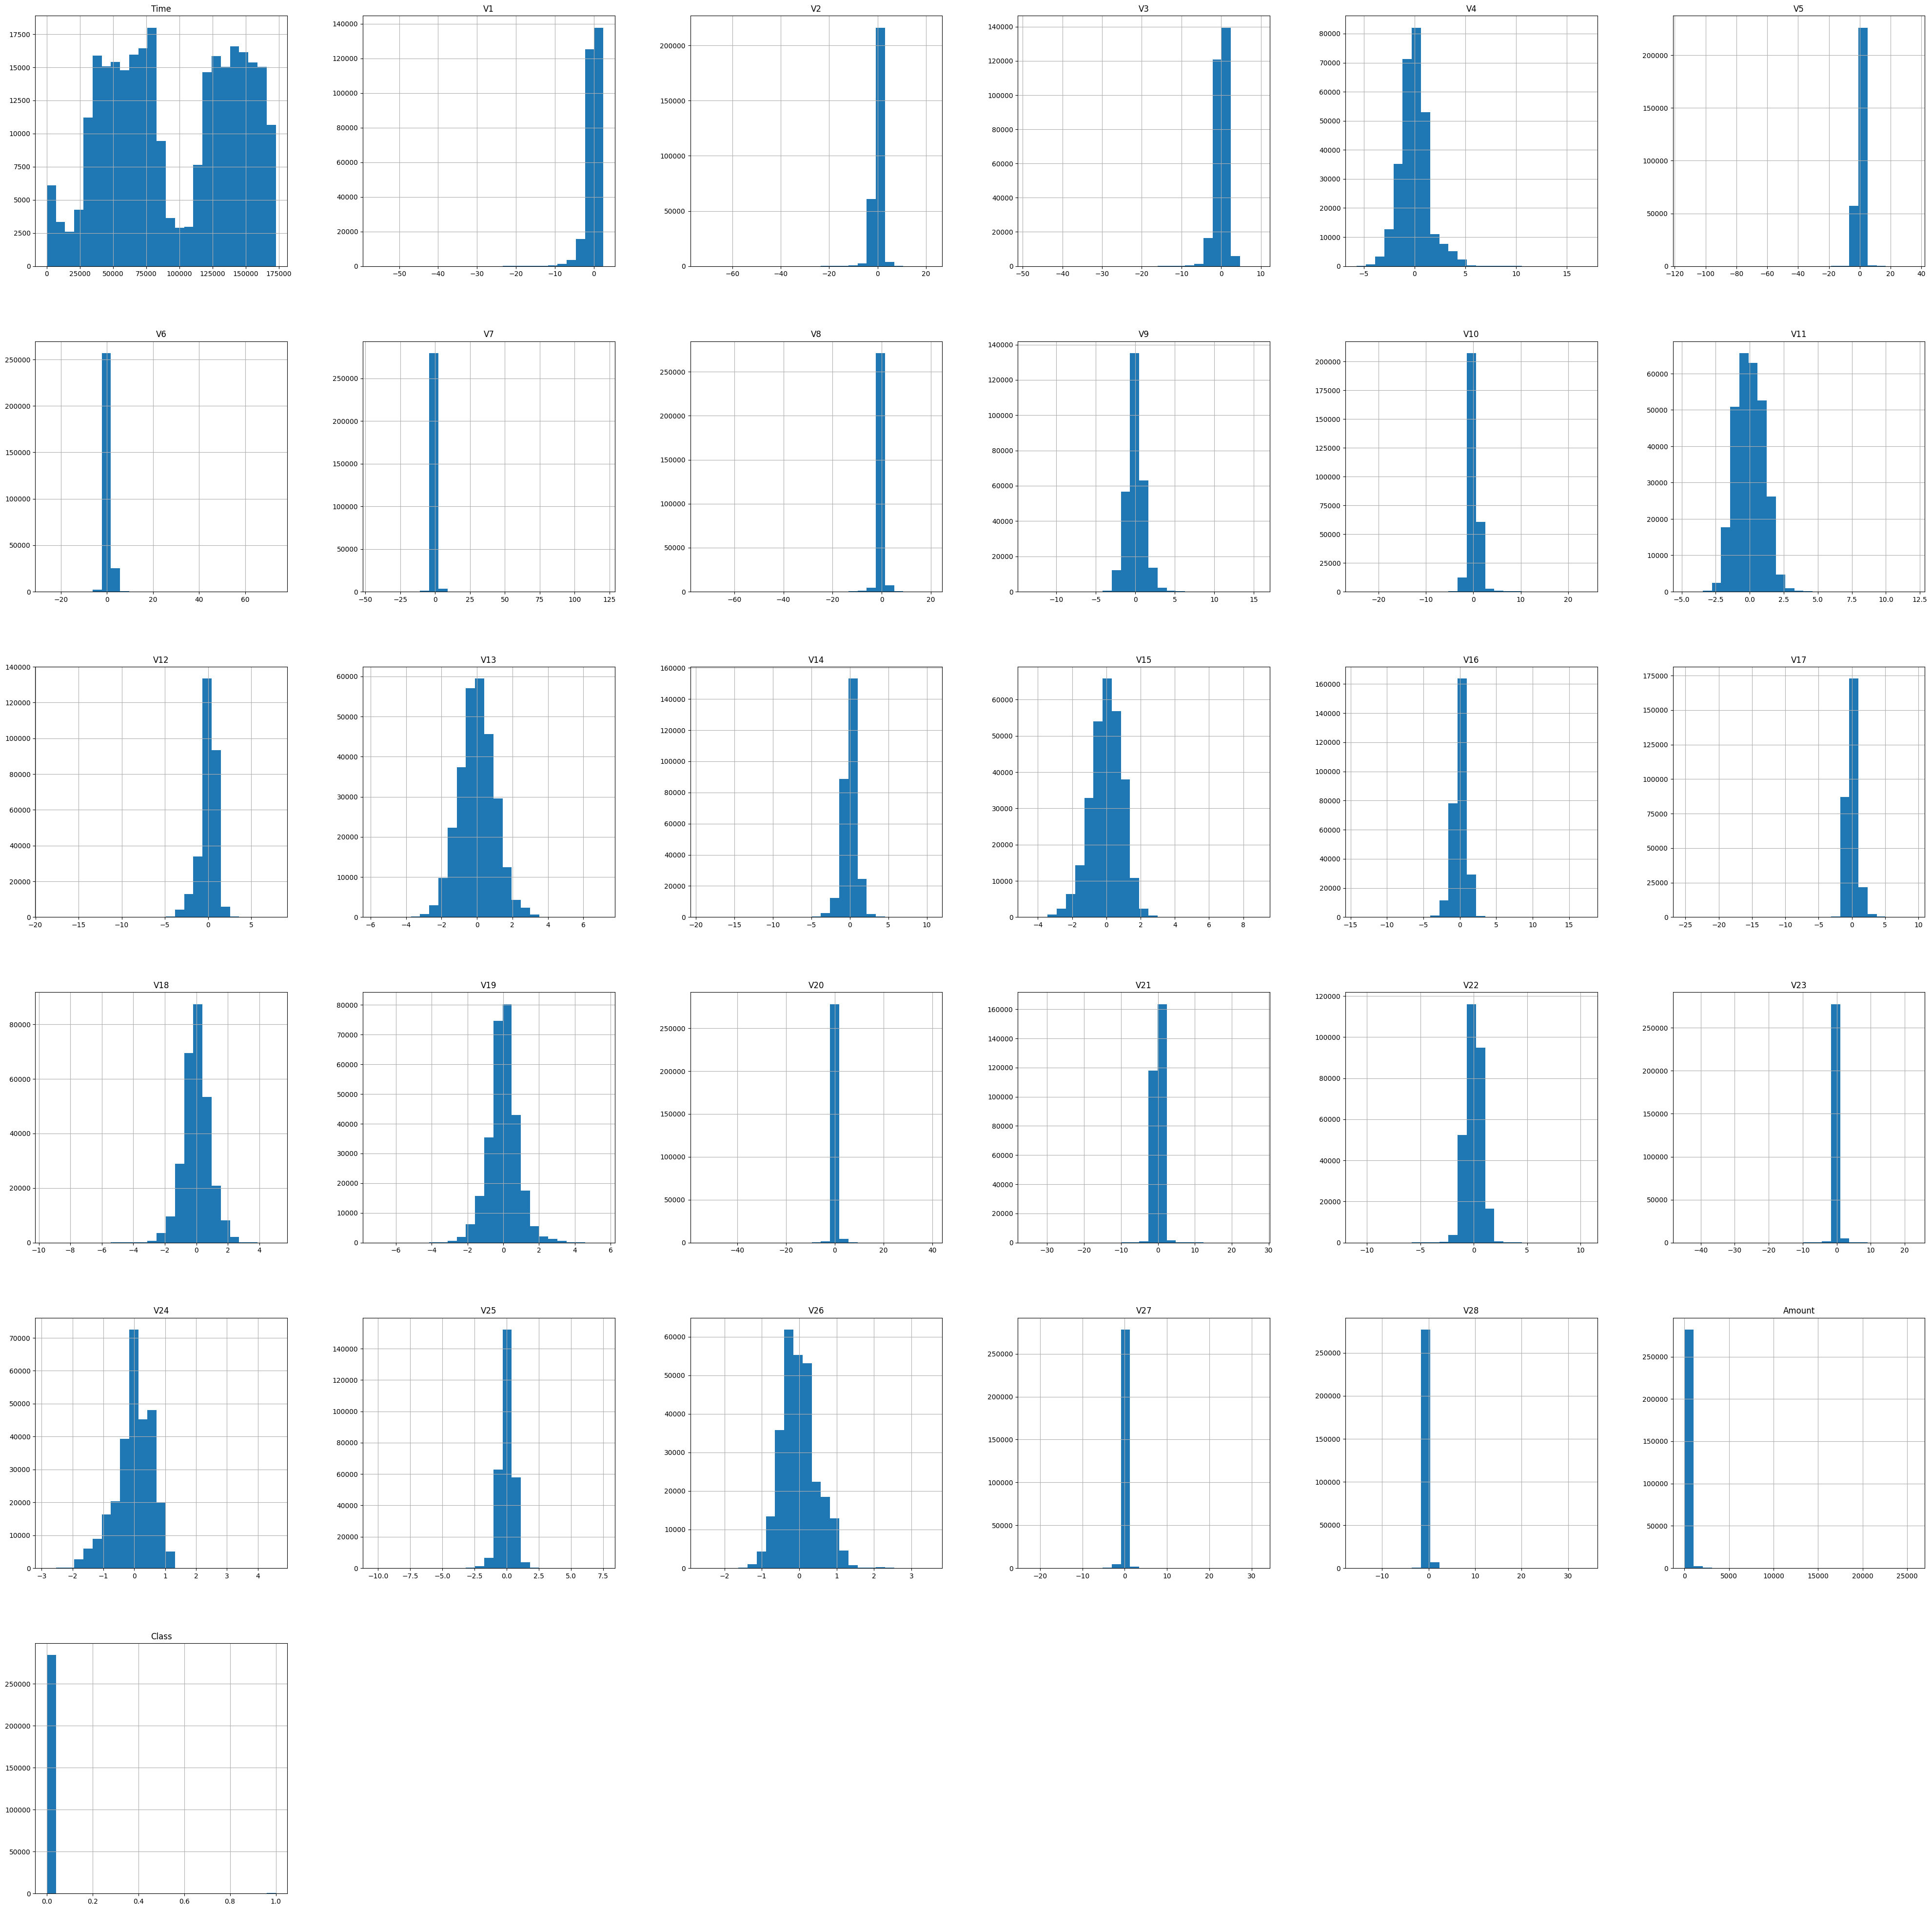

In [68]:
pf.hist(bins=25, figsize=(50,50))

<Axes: >

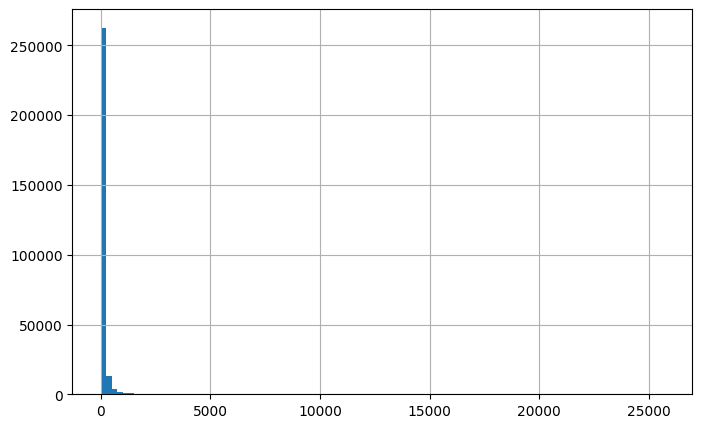

In [69]:
#Zoom in on the amount feature
pf["Amount"].hist(bins=100, figsize=(8, 5))

<Axes: >

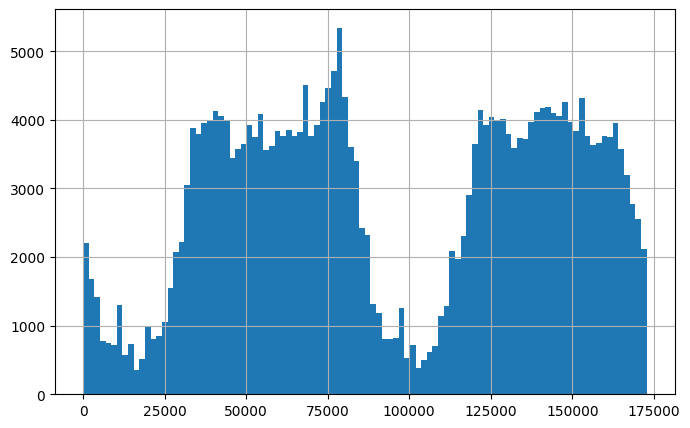

In [70]:
# Zoom in on the Time feature
pf["Time"].hist(bins=100, figsize=(8,5))

# Feature Engineering

In [5]:
# MinMax normalization 
new_pf = pf.copy()
new_pf["Time"] = MinMaxScaler().fit_transform(new_pf["Time"].to_numpy().reshape(-1,1))
new_pf["Amount"] = MinMaxScaler().fit_transform(new_pf["Amount"].to_numpy().reshape(-1,1))

In [65]:
new_pf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,0.548717,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.003439,0.001727
std,0.274828,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.009736,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,0.313681,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000218,0.000000
50%,0.490138,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000856,0.000000
75%,0.806290,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.003004,0.000000
max,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,1.000000


In [ ]:
# How would you rescale the entire dataset at once?

# pf_just_for_review = pf.copy()
# # The fit_transform method learns the parameters from the training data (fit) and then 
# # applies the transformation using those learned parameters (transform) in one step.
# new_pf_just_for_review = MinMaxScaler().fit_transform(pf_just_for_review.to_numpy())

# # Convert numpy array back to DataFrame
# new_pf_just_for_review = pd.DataFrame(new_pf_just_for_review, columns=pf_just_for_review.columns)
# new_pf_just_for_review.describe()

#### Separate the features from the ground truth

In [6]:
Y = new_pf["Class"]
X = new_pf.drop("Class", axis=1)

In [64]:
X.shape

(284807, 30)

#### Split the dataset into train, validation and test set

In [7]:
x_train,x_,y_train,y_ = train_test_split(X, Y, test_size= 0.4, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_, y_, test_size= 0.5, random_state=42)

# Delete temporary variables x_ and y_
del x_,y_ 

# Model building

In this section, we'll build our candidate models. 

As we saw in the last sections, our dataset is heavily imbalanced and we'll see its impact on model accuracy.

To mitigate this problem, we'll build three versions of each candidate model: 

- **imbalanced**: models with this label are trained on the entire training set,
  
- **balanced**: these models are trained on a re-balanced dataset by downsampling the majority class,
  
- **weighted**: trained on the entire training set with a weighted loss function. Weights are inversely proportional to the size of each class so that minority classes get higher weight.


We'll use these metrics to weigh the performance of our models:

- **Accuracy**: is a global metric which equally treats classes

$$\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}$$

- **Recall**:
A proportion of the positive class that the model predicts correctly.
A low recall means high number of False Negatives - fraudulent transactions predicted as normal ones, while high recall means the model performs very well on the positive class by having a few number of False Negatives.
  

$$\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}$$
  
- **Precision**: provides insight into the number of false positives - normal transactions predicted as fraudulent ones. High precision means low number of false positives, and vice-versa.

$$\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}$$
  
- **F1-score**: provides insight into both Recall and Precision. It's defined such that high F1 score means high Recall and high Precision value.

$$\text{F1-score} = \frac{1}{\frac{1}{2} \times (\frac{1}{\text{Recall}} + \frac{1}{\text{Precision}})}$$



## Helper Functions

In [15]:
def displayLearningCurves(model, X, Y, train_sizes, perf_metric, name, version):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(f"Learning Curves of the {version}_{model.__class__.__name__} classifier")
    common_params = {
        "X": X,
        "y": Y,
        "train_sizes": train_sizes,
        "score_type": 'both',
        "cv": 5,  # As we're working with a classification problem cv used StratifiedKFold strategy
        "scoring": perf_metric,
        "n_jobs": 4,
        "line_kw": {"linestyle": "-", "marker": "o"},
        "score_name": name,
        "ax": ax
    }
    LearningCurveDisplay.from_estimator(estimator=model, **common_params)

In [ ]:
# from sklearn.metrics import recall_score



# # Create classifier with more estimators to see the progression
# gb_clf = HistGradientBoostingClassifier(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=2,
#     random_state=42
# )

# # Fit the model
# gb_clf.fit(x_train, y_train)

# # Get training and validation scores for each boosting iteration
# train_scores = []
# val_scores = []

# for i, pred in enumerate(gb_clf.staged_predict(x_train)):
#     train_scores.append(recall_score(y_train, pred))

# for i, pred in enumerate(gb_clf.staged_predict(x_val)):
#     val_scores.append(recall_score(y_val, pred))

# # Plot the training progression
# plt.figure(figsize=(12, 8))

# # Plot 1: Accuracy vs Iterations
# plt.subplot(2, 1, 1)
# iterations = range(1, len(train_scores) + 1)
# plt.plot(iterations, train_scores, label='Training Accuracy', color='blue')
# plt.plot(iterations, val_scores, label='Validation Accuracy', color='red')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Accuracy')
# plt.title('Training Progress - Accuracy vs Boosting Iterations')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Training Loss (if available)
# plt.subplot(2, 1, 2)
# plt.plot(range(1, len(gb_clf.train_score_) + 1), gb_clf.train_score_, 
#          label='Training Loss', color='green')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Loss')
# plt.title('Training Loss vs Boosting Iterations')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print some insights
# print(f"Best training accuracy: {max(train_scores):.4f} at iteration {np.argmax(train_scores) + 1}")
# print(f"Best validation accuracy: {max(val_scores):.4f} at iteration {np.argmax(val_scores) + 1}")
# print(f"Final training accuracy: {train_scores[-1]:.4f}")
# print(f"Final validation accuracy: {val_scores[-1]:.4f}")

# # Check for overfitting
# if max(train_scores) - max(val_scores) > 0.05:
#     print("Warning: Potential overfitting detected (large gap between train and validation)")
# else:
#     print("Model appears to be well-regularized")

In [ ]:
# x = np.arange(0.,1.1,0.1)
# y_1 = -np.log(x)
# y_2 = -np.log(1-x)

In [ ]:
# fig,ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
# ax[0].plot(x,y_1, c='blue')
# ax[0].set_xlabel('Probability p')
# ax[0].set_ylabel('Entropy when y_i = 1')
# ax[1].plot(x,y_2, c='blue')
# ax[1].set_ylabel('Entropy when y_i = 0')
# ax[1].set_xlabel('Probability p')
# plt.show()

## Working with Imbalanced Versions

#### Logistic Regression

We're dealing with a classification problem! Given a transaction, our model should predict wheither it's fraudulent (1) or non-fraudulent(0) transaction. 

The logistic regression is one of the core ML classification algorithms. 
the logistic regression name might be a bit confusing, the regression part comes from the fact that the mathematical formulation of the logistic regression is very similar to that of the linear regression.

- In linear regression, the predictive function or model ${y_i}$ is defined as linear combination of the input data ${x_i}$ : ${y_i} = {w^{T}}{x_i} + {b}$ where (w,b) are the model parameters.


- In Logistic regression, the output takes discrete values, in this case 0 or 1 (binary classification) and therefore the predictive function defined earlier for linear regression would not work. We apply the logistic function to the linear combination of the input data. You can think of this function as the probability of a transaction being fraudulent. Obviously, it ranges from 0 to 1: depending on a threshold, transactions with probability value higher than the threshold would be classified as fraudulent and those with less than the threshold are the normal ones. The predictive function for logistic regression is defined as follow:


$${f_{w,b}({x_i})} = \frac{1}{1+\exp^{-({w^{T}}{x_i} + {b})}}$$


Once we get to this point, we need to define our **cost function** ${J({w,b})}$ which measures how well our model fits the data. The whole process of training an ML models is about tweaking the parameter to minimize this cost function. They are multiple ways to define a cost function. For logistic regression, the cost function is defined as the likelihood of the parameters, a probabilistic approach function that tells us how likely a set of paramters (and therefore the model) has generated the data. By maximizing this function, we get the best parameters that allows the model to fit well to the data. This estimation method of the parameter is called **Maximum likelihood estimation (MLE)**.

Since most of the optimization algorithms are designed to minimize cost functions, the likelihood is transformed into the negative log likelihood as follow:

$$ J({w,b}) = - \frac{1}{m}\sum\limits_{i = 1}^{m}(y_{i})\log\left(f_{\mathbf{w},b}\left( \mathbf{x}_{i} \right) \right) + \left( 1 - y_{i}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}_{i} \right) \right)$$



During the training process, the optimization algorithm, **Gradient descent**, is then applied to find parameters $\mathbf(w,b)$ that minimize this function.


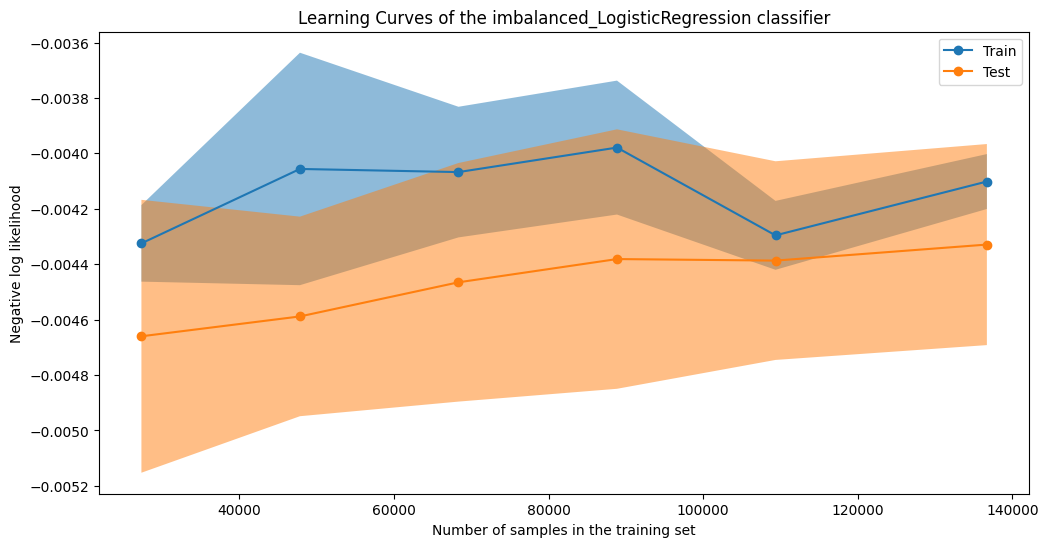

In [17]:
logistic_model_1 = LogisticRegression(max_iter=1000)
displayLearningCurves(
    logistic_model_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'imbalanced'
)

In [18]:
logistic_model_1.fit(x_train, y_train)
print(classification_report(y_val, logistic_model_1.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56869
       Fraud       0.87      0.66      0.75        93

    accuracy                           1.00     56962
   macro avg       0.94      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



#### Decision trees


Decision tree algorithm is one of the most versatile algorithms which can be used in classification as well as in regression problems. In this section, we are going to use them as classifier to predict whether a transaction is fraudulent or not. 

You can think of decision tree as acyclic graph in which you have nodes and routes making the connection between nodes. At each node, the algorithm needs to take action (take one route or the other) based on certain condition (usually the condition is based on values of the feature at that node). The goal of the algorithm is to help us find the best features that recursively split the dataset into homogeneous subsets that lead ultimately to the target class (last nodes called leaf nodes).

The training process of a decision tree model is based on the homogeneity of subsets. To define it, we use something called **entropy** which is inversely proportional to the homogeneity of a subset, the more homogeneous a subset is the lower the entropy. At each node, we'll have two substets ${S_1}$ and ${S_2}$ with ${n_1}$ and ${n_2}$ their corresponding numbers of transactions. The weighted-average entropy of the two substets captures the the ability of a feature to create sparse data (less homogeneous subset).

- For a given subset with $p_1$ the proportion of fraudulent transactions, the entropy is given by: 

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1 - p_1) \text{log}_2(1- p_1)$$

- the weighted-average entropy (WAE) is then:
$$\text{WAE} = \dfrac{n_1}{{n_1}+{n_2}}{H^{S_1}}(p_1) + \dfrac{n_2}{{n_1}+{n_2}}{H^{S_2}}(p_1)$$

Again for convenience, we prefer the **information gain** which measures the reduction of the entropy after the split. if $H(S)$ denotes the entropy of a node, then the information gain is defined as follow:

$$\text{Information Gain} = H(S)- \text{WAE}$$

The splitting process continues until a stopping criteria is met which is the maximum depth(number of branches to go from the root node to the leaf nodes, max_depth = 2)


However, one of the main drawbacks of decision tree is that it's too sensitive to even small changes in the dataset. 
- **Random forest** is a set of decision trees built upon different samples drawn from the original dataset by sampling with replacement. Moreover, at each node, when choosing a feature to use to split, if n features are available, it picks a random subset of ${k<n}$ features and allow the algorithm to only choose from that subset of features. A typical choice for k when n is too large is ${\sqrt{n}}$.

- **XGBoost** is a variant of random forest, instead of picking from all examples with equal probability p, we make it more likely to pick data point that the **previous tree is misclassifiying**.

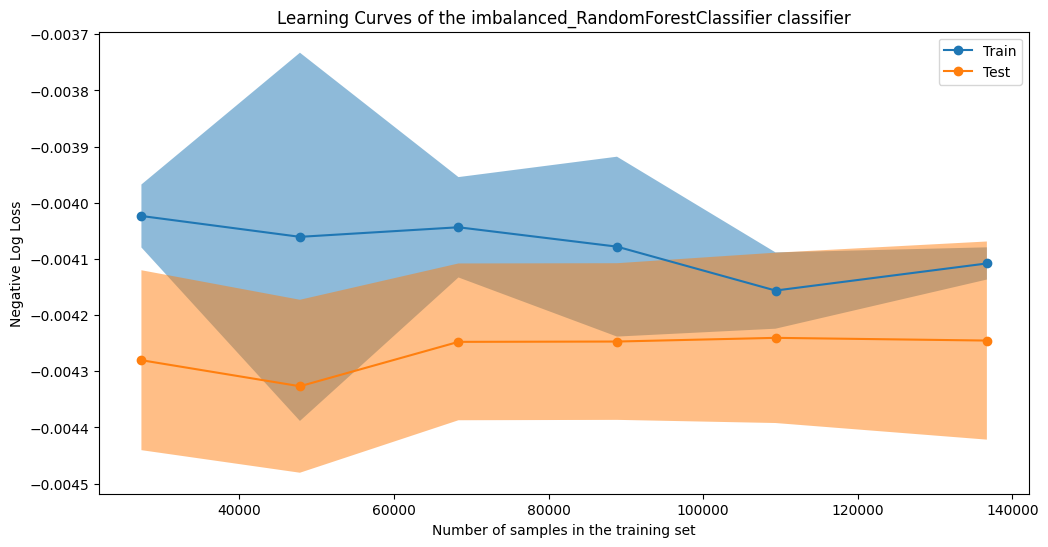

In [19]:
rf_1 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
displayLearningCurves(
    rf_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)

In [20]:
rf_1.fit(x_train,y_train)
print(classification_report(y_val, rf_1.predict(x_val), target_names = ['Non-fraudulent','Fraudulent']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56869
       Fraud       0.86      0.60      0.71        93

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



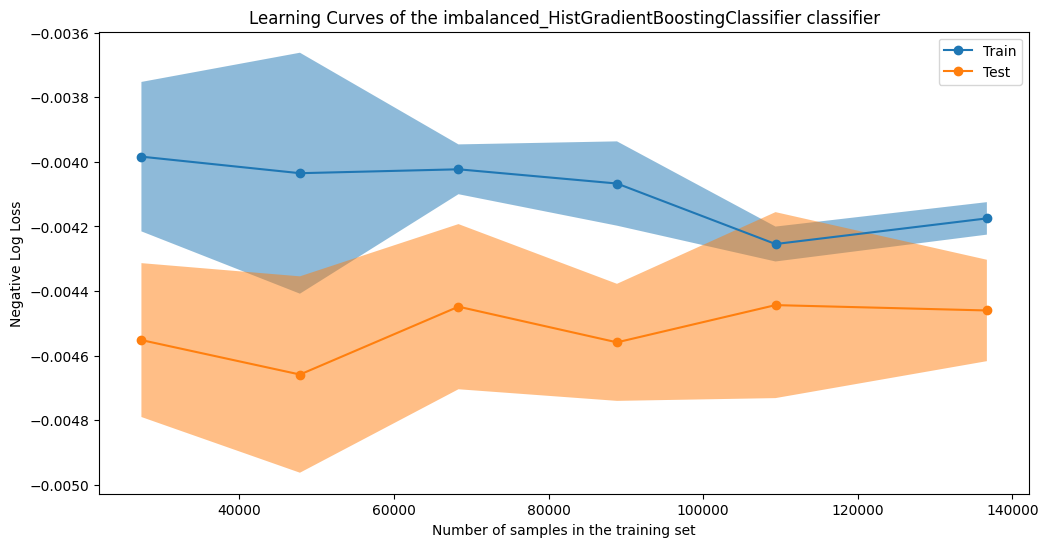

In [26]:
xgb_1= HistGradientBoostingClassifier(max_depth=2, learning_rate= 0.01,  early_stopping=True, random_state=42)
# early_stopping prevents the model from overfitting the training data
# l2_regularization=0.01

displayLearningCurves(
    xgb_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'imbalanced'
)


In [27]:
xgb_1.fit(x_train,y_train)
print(classification_report(y_val, xgb_1.predict(x_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.86      0.75      0.80        93

      accuracy                           1.00     56962
     macro avg       0.93      0.88      0.90     56962
  weighted avg       1.00      1.00      1.00     56962



#### Support Vector Machine

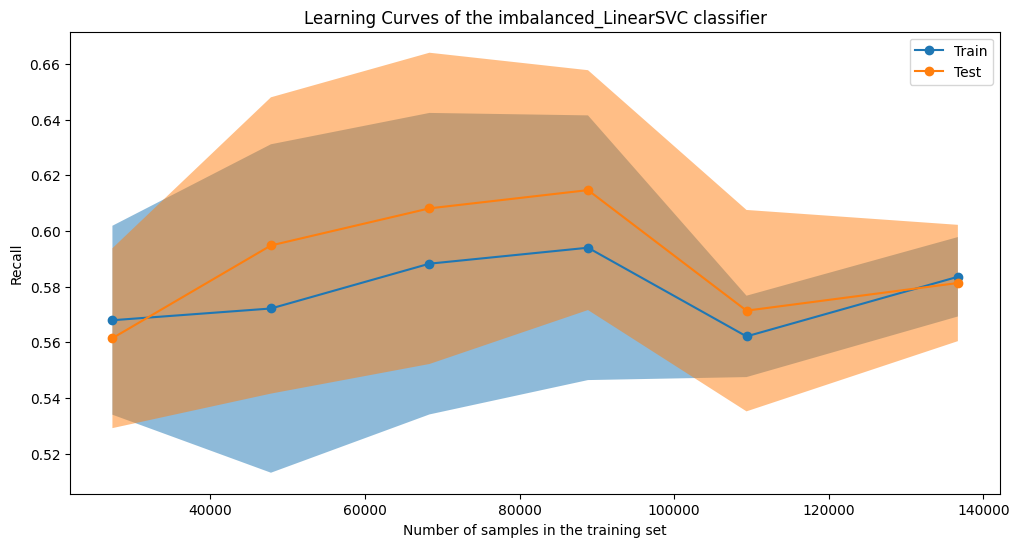

In [28]:
svc_1 = LinearSVC()

displayLearningCurves(
    svc_1, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'imbalanced'
)


In [29]:
svc_1.fit(x_train, y_train)
print(classification_report(y_val, svc_1.predict(x_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.88      0.63      0.74        93

      accuracy                           1.00     56962
     macro avg       0.94      0.82      0.87     56962
  weighted avg       1.00      1.00      1.00     56962



### Wrap up:

If you've been paying attention to the accuracy of all models, you may have noticed that the model accuracy is always equal to 1 surprisingly. This is because accuracy is a global metric that treats all classes equally. As a consequence, the class with high frequence dominates the metric. In our case the fraudulent class represents less than 1% of the dataset which is highly imbalanced and makes accuracy a misleading metric of the model performance.

The second thing to notice is that our models do not overfit, which is a good news. But something interesting is happening when the size of the training set is around 110,000, the training loss starts slowly increasing while the validation loss is relatively constant. This is probably because as the training goes on, more and more less frequent data points (fraudulent transactions) are added to the training set. The model - not used to them - hardly predicts them correctly. 

The golden model with regard to precision and recall of this section: **xgb_1** with **Precision = 0.86** and **Recall = 0.75**

## Working with Balanced Versions

#### Re-balancing the dataset

In [30]:
new_pf_copy = new_pf.copy()
non_fraud_pf = new_pf_copy[new_pf_copy["Class"] == 0].reset_index(drop=True) # indexes get dropped and restart from 0
fraud_pf = new_pf_copy[new_pf_copy["Class"] == 1].reset_index(drop=True)
non_fraud_pf.info()
#fraud_pf.info()

#Downsample the non_fraud datatframe
non_fraud_pf = resample(
    non_fraud_pf,
    replace= True, 
    n_samples= len(fraud_pf), 
    random_state= 42
).reset_index(drop=True)
print("\n\n\n")
non_fraud_pf.info()

balanced_pf = pd.concat([non_fraud_pf, fraud_pf], axis= 0, ignore_index= True)\
                .sample(frac=1, random_state=42)\
                .reset_index(drop=True)

print("\n\n\n The dataset is now balanced\n")
balanced_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284315 entries, 0 to 284314
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284315 non-null  float64
 1   V1      284315 non-null  float64
 2   V2      284315 non-null  float64
 3   V3      284315 non-null  float64
 4   V4      284315 non-null  float64
 5   V5      284315 non-null  float64
 6   V6      284315 non-null  float64
 7   V7      284315 non-null  float64
 8   V8      284315 non-null  float64
 9   V9      284315 non-null  float64
 10  V10     284315 non-null  float64
 11  V11     284315 non-null  float64
 12  V12     284315 non-null  float64
 13  V13     284315 non-null  float64
 14  V14     284315 non-null  float64
 15  V15     284315 non-null  float64
 16  V16     284315 non-null  float64
 17  V17     284315 non-null  float64
 18  V18     284315 non-null  float64
 19  V19     284315 non-null  float64
 20  V20     284315 non-null  float64
 21  V21     28

#### train, val, test sets

In [31]:
Yb = balanced_pf["Class"]
Xb = balanced_pf.drop("Class", axis=1)

#Splitting into training, eval and test sets
xb_train,xb_,yb_train,yb_ = train_test_split(Xb, Yb, test_size= 0.4, random_state=42)
xb_test,xb_val,yb_test,yb_val = train_test_split(xb_, yb_, test_size= 0.5, random_state=42)

# Delete temporary variables x_ and y_
del xb_,yb_ 

#### Logistic Regression 

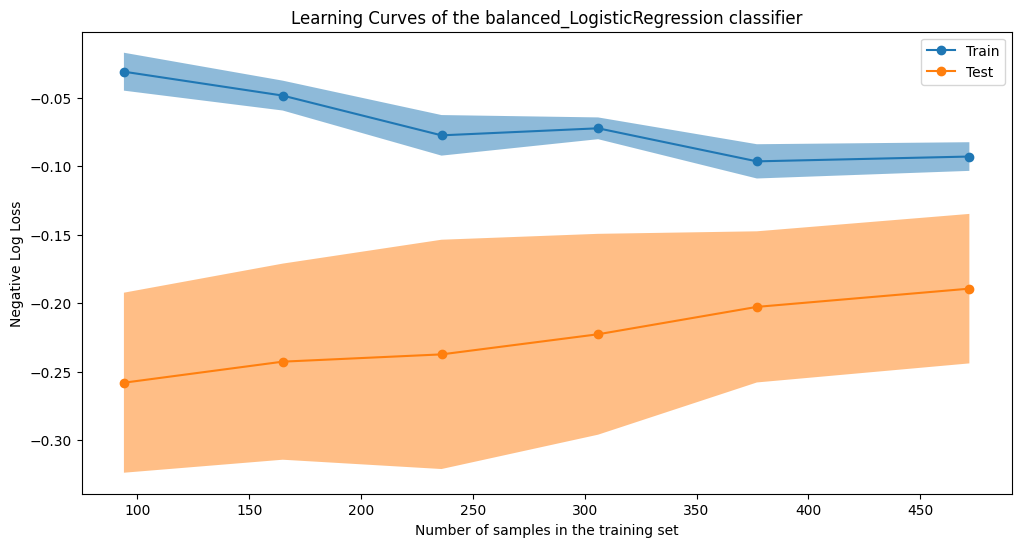

In [32]:
logistic_model_2 = LogisticRegression(max_iter=1000)
displayLearningCurves(
    logistic_model_2 , 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced'
)


In [33]:
logistic_model_2.fit(xb_train, yb_train)
print(classification_report(yb_val, logistic_model_2.predict(xb_val), target_names=['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.92      0.97      0.95       113
    Fraudulent       0.96      0.89      0.93        84

      accuracy                           0.94       197
     macro avg       0.94      0.93      0.94       197
  weighted avg       0.94      0.94      0.94       197



#### Decision trees 

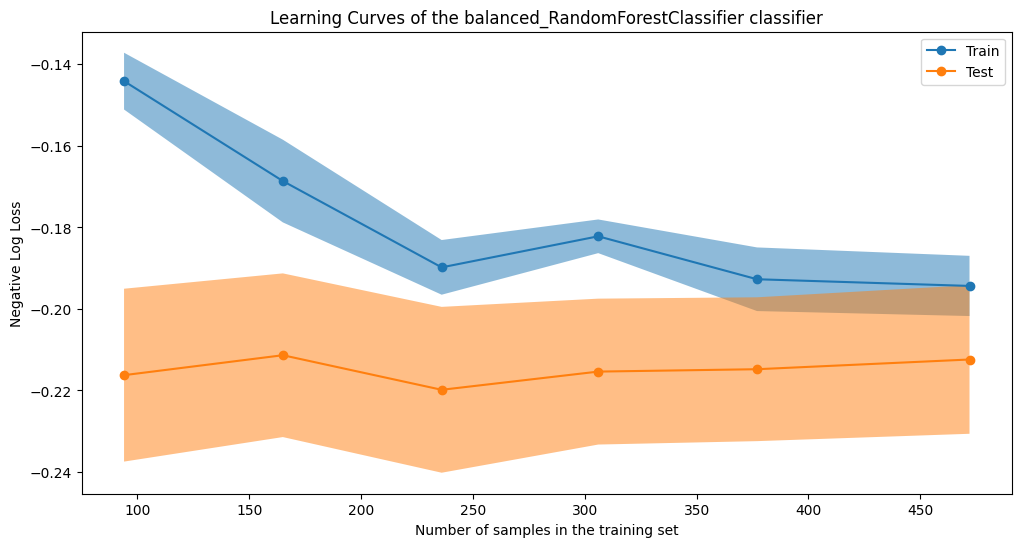

In [34]:
rf_2 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42)
displayLearningCurves(
    rf_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced'
)


In [35]:
rf_2.fit(xb_train, yb_train)
print(classification_report(yb_val, rf_2.predict(xb_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.88      1.00      0.94       113
    Fraudulent       1.00      0.82      0.90        84

      accuracy                           0.92       197
     macro avg       0.94      0.91      0.92       197
  weighted avg       0.93      0.92      0.92       197



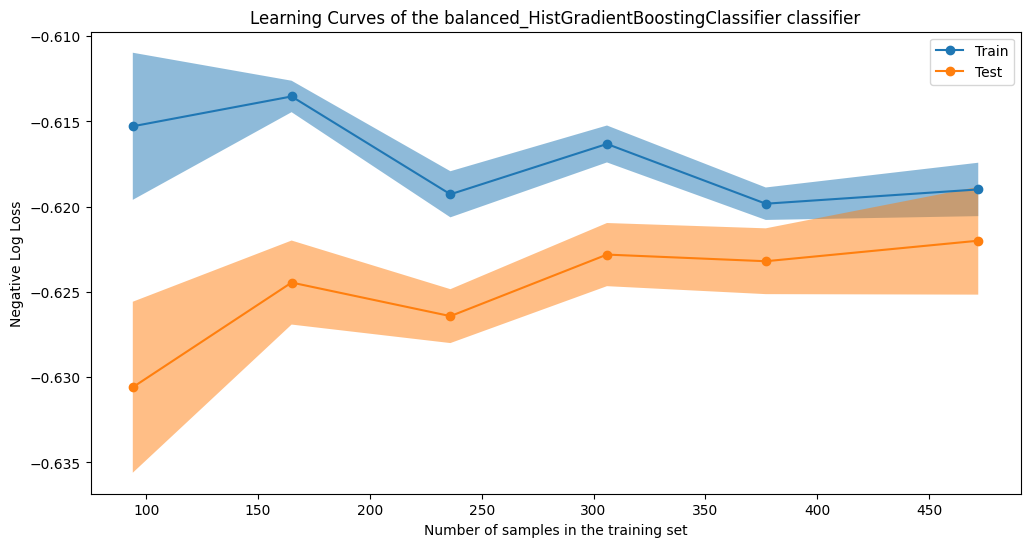

In [43]:
xgb_2 = HistGradientBoostingClassifier(max_depth=2, learning_rate= 0.001,  early_stopping=True, random_state=42)

displayLearningCurves(
    xgb_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative Log Loss',
    'balanced',
)


In [44]:
xgb_2.fit(xb_train,yb_train)
print(classification_report(yb_val, xgb_2.predict(xb_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.94      0.93      0.93       113
    Fraudulent       0.91      0.92      0.91        84

      accuracy                           0.92       197
     macro avg       0.92      0.92      0.92       197
  weighted avg       0.92      0.92      0.92       197



#### Support Vector Machine 

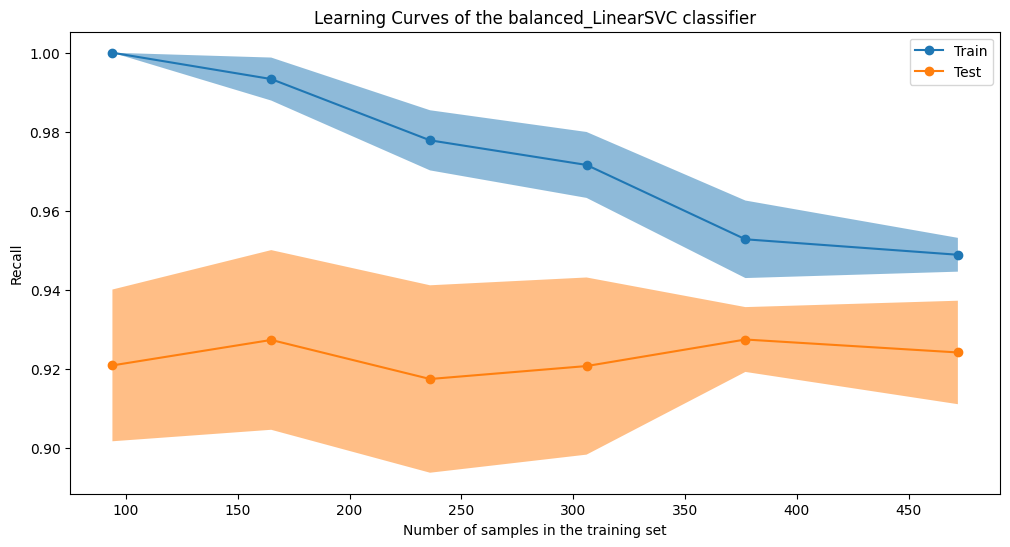

In [48]:
svc_2 = LinearSVC()
displayLearningCurves(
    svc_2, 
    xb_train, 
    yb_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'balanced'
)


In [46]:
svc_2.fit(xb_train,yb_train)
print(classification_report(yb_val, svc_2.predict(xb_val), target_names = ['Non-fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-fraudulent       0.92      0.96      0.94       113
    Fraudulent       0.94      0.89      0.91        84

      accuracy                           0.93       197
     macro avg       0.93      0.92      0.93       197
  weighted avg       0.93      0.93      0.93       197



### Wrap up:

The first thing to notice is that the accuracy is no longer constant and set to 1 as the dataset si now fairly distributed.

Again, our models did not overfit the training data. Having a balanced dataset helped models equally encounter fraudulent transactions and normal ones, making them more robust. In contrast to the previous section, the training loss no longer increases toward the end of the training process. It looked more like reaching a plateau in most cases, which confirms our previous assumption.

The golden model of this section: **xgb_2** with **Precision = 0.91** and **Recall = 0.92**

## Working with Weighted Versions

#### Logistic Regression

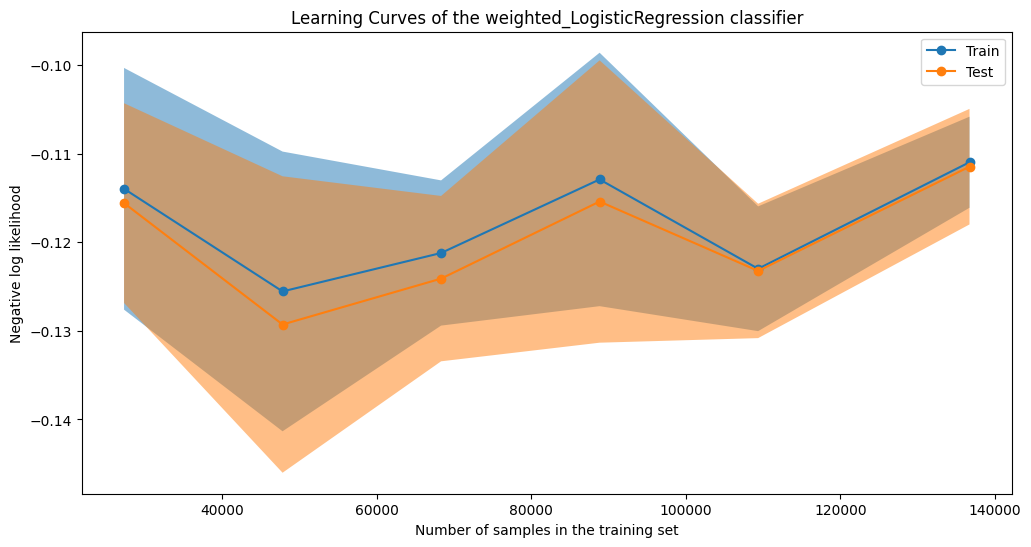

In [49]:
logistic_model_3 = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)
displayLearningCurves(
    logistic_model_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)

In [58]:
# print(hasattr(logistic_model_2, 'coef_'))
logistic_model_3.fit(x_train, y_train)
print(classification_report(y_val, logistic_model_3.predict(x_val), target_names=['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56869
    Fraudulent       0.06      0.91      0.11        93

      accuracy                           0.98     56962
     macro avg       0.53      0.95      0.55     56962
  weighted avg       1.00      0.98      0.99     56962



#### Decision trees

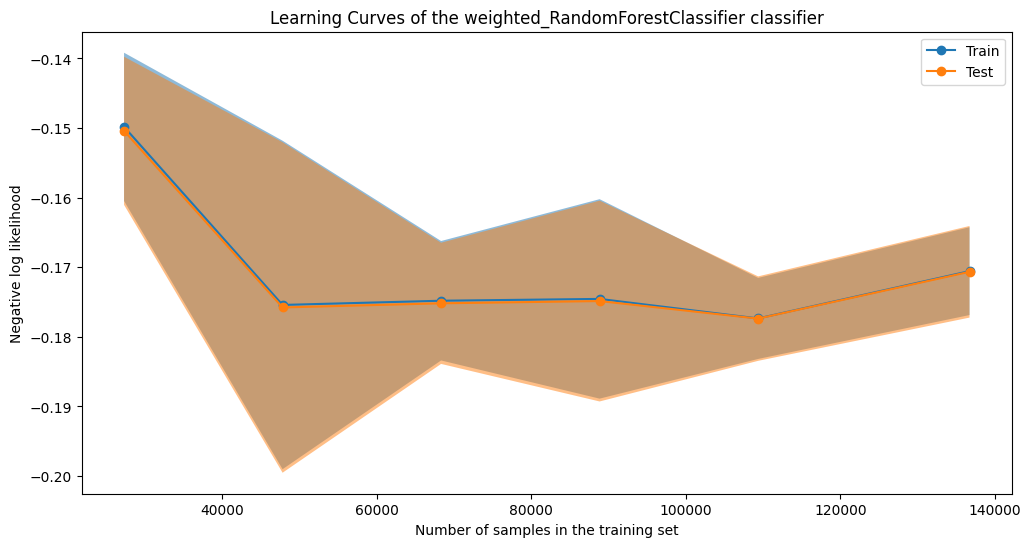

In [51]:
rf_3 = RandomForestClassifier(max_depth=2, n_jobs=-1, random_state=42, class_weight='balanced')
displayLearningCurves(
    rf_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'neg_log_loss',
    'Negative log likelihood',
    'weighted'
)

In [59]:
rf_3.fit(x_train,y_train)
print(classification_report(y_val, rf_3.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     56869
    Fraudulent       0.34      0.88      0.49        93

      accuracy                           1.00     56962
     macro avg       0.67      0.94      0.75     56962
  weighted avg       1.00      1.00      1.00     56962



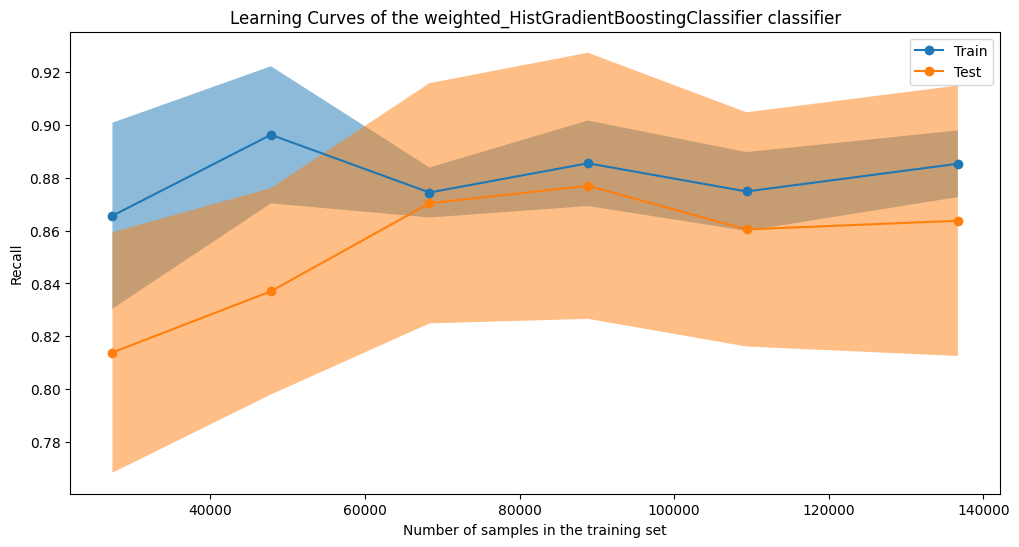

In [62]:
xgb_3 = HistGradientBoostingClassifier(max_depth=2, learning_rate= 0.01, early_stopping=True, class_weight='balanced')


displayLearningCurves(
    xgb_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'weighted',
)


In [63]:
xgb_3.fit(x_train,y_train)
print(classification_report(y_val, xgb_3.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56869
    Fraudulent       0.06      0.88      0.12        93

      accuracy                           0.98     56962
     macro avg       0.53      0.93      0.55     56962
  weighted avg       1.00      0.98      0.99     56962



#### Support Vector Machine

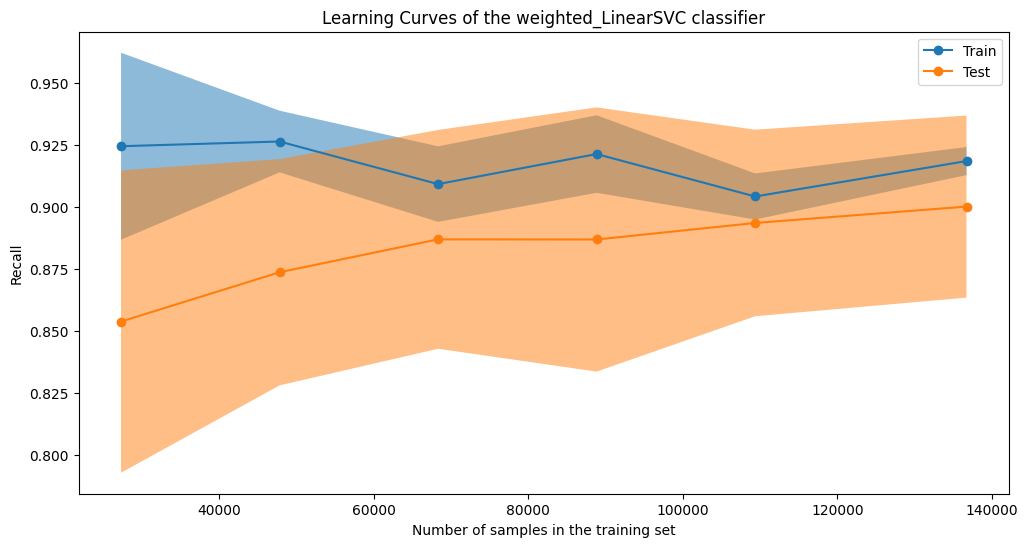

In [56]:
svc_3 = LinearSVC(class_weight='balanced')
displayLearningCurves(
    svc_3, 
    x_train, 
    y_train, 
    [0.2, 0.35, 0.5, 0.65, 0.80, 1],
    'recall',
    'Recall',
    'weighted'
)


In [61]:
svc_3.fit(x_train,y_train)
print(classification_report(y_val, svc_3.predict(x_val), target_names = ['Non-Fraudulent','Fraudulent']))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      0.98      0.99     56869
    Fraudulent       0.08      0.92      0.14        93

      accuracy                           0.98     56962
     macro avg       0.54      0.95      0.57     56962
  weighted avg       1.00      0.98      0.99     56962



### Wrap up:

In this section, we used the weighted loss function method to handle the class imbalance problem. 

As the weight of each class is inversely proportional to its size, the models payed more attention to the minority class.

As a consequence the recall of these models is globally higher, but the precision is a lot lower because they misclassify a lot of normal transactions as fraudulent ones, making the number of False Positive higher.

Models did not overfit once again. 

The golden model is **rf_3** with **Precision = 0.34** and **Recall = 0.88**

# Conclusion

In this project, we worked on a heavily imbalanced dataset. 

We saw that accuracy is not the best performance metric when it comes to working with imbalanced data. Asymetric metrics - by asymetric I mean class-dependent - such as Precision, Recall provide more valuable insight in this case.

We explored four ML algorithms - LogisticRegression, RandomForestClassifier, HistGrandientBoostingClassifier and LinearSVC - each of them has been trained in three different scenarios to handle the class imbalance problem: imbalanced, balanced and weighted.

We looked for overfitting, fortunately our models didn't suffer from it.

**How to choose The Model?**

Choosing a model is hard, it's not just about maximizing performance metrics such as Precision and Recall. It requires domain expertise, sometimes model explainability(Banking industry) - not always the best performing model is the one in production. Building Ml systems is a team effort, if you as a ML engineer happens to have expertise in the domain you're working, it's great. But if it's not **Communication is Key**.

In our case, one may argue as we're building a credit card fraud detection model that the most important metric is **Recall** which is understandable as we want our model to have the least amount of False Negatives. Based on this criterion, I can choose the **svc_3 model** which has the best *Recall of 92%*. This model can perfectly fit the requirements, but what we didn't see is that it can also make you lose many of your clients. this model has a *Precision of 8%* meaning a lot of False Positives - It can be annoying to wait for a verification process any time we want to realize a transaction. 

So what would be the purpose of this ML system for a business without clients? 

